# Model description
Below, a mesa implementation is given of Eppstein's Civil Violence model 1. The basic idea of this model is the following. We have 2 types of agents: cops and citizens. Cops and Citizens both have a field of vision and they move every step to a random empty location within their field of vision. The agents are all located on a toroidal grid and each grid cell can only be occupied by at most a single agent. 

## Citizen
Citizens can protest (i.e. becomes $active$). They decide every tick, after having moved, whether or not they want to protest (i.e., become active). They make this decision based on their attributes. 

- attributes with unique values for each citizen:
    - hardship, drawn from $U(0, 1)$
    - risk aversion, drawn from $U(0, 1)$
- attributes with shared values across all Citizens (i.e., class level attributes):
    - perception of the legitimacy of the State, a user specified parameter between 0 and 1. 
    - threshold above which Citizens will protest, a user specified parameter usually set to a small positive value (e.g., 0.1).

An agent becomes active if: (Grievance - Net Risk) > Threshold. Otherwise the agent is $quiet$.

**Grievance** is calculated for each citizen as: 

$
    grievance = hardship * (1-legitimacy)
$

The **net risk** is the perceived chance of being arrested times the personal level of risk aversion. The perceived chance of being arrested is given by

$
    p = 1 - e^{(-1*k*round(c/a))}
$

Where:
- $k$ is an arrenst probability constant (set to 2.3 as default), 
- $c$ is the number of cops within the field of vision,
- $a$ is the number of active citizens within the field of vision including the agent itself (who considers herself always active).

So the net risk is:

$
net\_risk = p * risk\_aversion
$

## Cop
After having moved, the cop checks his field of vision for any active citizens. It then arrests a randomly selected active citizen within its field of vision. 

## Arrest
If a citizen is arrested, it cannot move. Upon arrest, a citizen also receives a random jail time, which is the number of ticks for which it remains under arrest. Jail time is drawn from $U(U, J_{max})$, where $J_{max}$ is a user specified parameter which can substantially alter the dynamics of the model. 

# Implementation details.
The model below is an implementation of the civil violence model. Given that the movement behavior and the way in which agents update their field of vision is the same for both Citizens and Cops, this functionality is implemented in a BaseAgent class. The Cop class and Citizen class both extend this BaseAgent class and add their respective behavior to it. The model itself uses a SingleGrid toroidol space. Class level attributes are used for legitimacy, vision, $k$, and activation threshold. Statistics collection is done using so called anonymous, or lambda functions. 


# Assignment 1
Given the description above and the provided implementation below, complete the model `__init__` function. The expected results are shown in the figure and you can use the provided plotting code to generate your results.

<div>
<img src="results.png" width="600"/>
</div>

In [1]:
import math
from enum import Enum

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import random

from mpl_toolkits.axes_grid1 import make_axes_locatable

from mesa import Model, Agent
from mesa.time import RandomActivation
from mesa.space import SingleGrid
from mesa.datacollection import DataCollector


class CitizenState(Enum):
    ACTIVE = 1    
    QUIET = 2    
    ARRESTED = 3

def count(model, state):
    """Counts the number of citizens with the user-defined state"""
    count = 0
    for agent in model.schedule.agents:
        if isinstance(agent, Cop):
            continue
        else:
            if agent.state == state:
                count += 1
    return count

class CivilViolence(Model):
    """Model class for Eppstein's Civil Violence model I.
    
    The initial values are from Eppstein's article.
    """

    def __init__(self, height=40, width=40, citizen_density=0.7, citizen_vision=7,
        legitimacy=0.82, activation_treshold=0.1, arrest_prob_constant=2.3,
        cop_density=0.04, cop_vision=7, max_jail_term=15, seed=None):
        super().__init__(seed=seed)

        assert (citizen_density+cop_density) < 1
        
        # setup Citizen class attributes
        Citizen.vision = citizen_vision
        Citizen.legitimacy = legitimacy
        Citizen.arrest_prob_constant = arrest_prob_constant
        Citizen.activation_threshold = activation_treshold
        
        # setup Cop class attributes
        Cop.vision = cop_vision
        Cop.max_jail_term = max_jail_term

        # setup data collection
        model_reporters = {'active': lambda m: count(m, CitizenState.ACTIVE),
                           'quiet': lambda m: count(m, CitizenState.QUIET),
                           'arrested': lambda m: count(m, CitizenState.ARRESTED)}
       
        self.datacollector = DataCollector(model_reporters=model_reporters)
        self.schedule = RandomActivation(self)
        self.grid = SingleGrid(width, height, torus=True)

        # Set up agents
        id = 1
        for (_, x, y) in self.grid.coord_iter():
            pos = (x,y)
            
            klass = random.choices([Citizen, Cop, None],
                                   cum_weights=[citizen_density,
                                                citizen_density+cop_density, 1])[0]
            if klass: 
                agent = klass(id, self)
                id += 1
                self.grid.position_agent(agent, (x, y))
                self.schedule.add(agent)
        
        self.datacollector.collect(self)
        
    def step(self):
        """
        Run one step of the model.
        """
        self.schedule.step()
        self.datacollector.collect(self)


class BaseAgent(Agent):
    '''Base Agent class implementing vision and moving
    
    Attributes
    ----------
    moore : boolean
    
    '''    
    moore = False
    
    def get_agents_in_vision(self):
        """
        identify cops and active citizens within vision
        
        Returns
        -------
        tuple with list of cops, and list of active citizens
        
        """
        cops = []
        active_citizens = []
        
        for cell in self.model.grid.get_neighbors(self.pos,
                         moore=BaseAgent.moore, radius=self.__class__.vision):
            if isinstance(cell, Cop):
                cops.append(cell)
            elif cell.state == CitizenState.ACTIVE:
                active_citizens.append(cell)    
        return cops, active_citizens
    
    def move(self):
        """
        identify all empty cells within vision and move
        to a randomly selected one.
        """
        empty = []
        for pos in self.model.grid.get_neighborhood(self.pos,
                        moore=BaseAgent.moore, radius=self.__class__.vision):        
            if self.model.grid.is_cell_empty(pos):
                empty.append(pos)
        
        if empty:
            new_pos = self.random.choice(empty)
            self.model.grid.move_agent(self, new_pos)
        
    
class Citizen(BaseAgent):
    '''Citizen class
    
    Attributes
    ----------
    legitimacy : boolean
    vision : int
    arrest_prob_constant : float
    activation_treshold : float
    hardship : float
    risk_aversion : float
    state : {CitizenState.QUIET, CitizenState.ACTIVE, CitizenState.ARRESTED }
    jail_time_remaining  :int
    grievance : float
    
    '''        
    legitimacy = 1
    vision = 1
    arrest_prob_constant = 1
    activation_treshold = 1
    
    def __init__(self, identity, model):
        super().__init__(identity, model)
        self.hardship = self.random.random()
        self.risk_aversion = self.random.random()
        self.state = CitizenState.QUIET
        self.jail_time_remaining = 0
        self.grievance = self.hardship*(1-Citizen.legitimacy)
        
    def _check_jail_time(self):
        if (self.state == CitizenState.ARRESTED) and (self.jail_time_remaining > 0):
            self.jail_time_remaining -= 1
        return self.jail_time_remaining

    def step(self):
        """
        move and then decide whether to activate
        """
        
        if self._check_jail_time() > 0:
            return
            
        self.move()
            
        cops, active_citizens = self.get_agents_in_vision()
        n_cops = len(cops)
        n_active_citizens = len(active_citizens) + 1 # self is always considerd active
            
        arrest_p = 1 - math.exp(-1*Citizen.arrest_prob_constant * round(n_cops/n_active_citizens))
        net_risk = self.risk_aversion * arrest_p
        
        if (self.grievance - net_risk) > self.activation_threshold:
            self.state = CitizenState.ACTIVE
        else:
            self.state = CitizenState.QUIET
        

class Cop(BaseAgent):
    '''Cop class
    
    Attributes
    ----------
    vision : int
    max_jail_term : int
    '''
    vision = 1
    max_jail_term = 1
        
    def step(self):
        self.move()
        cops, active_citizens = self.get_agents_in_vision()
        
        if active_citizens:
            citizen = self.random.choice(active_citizens)
            citizen.state = CitizenState.ARRESTED
            citizen.jail_time_remaining = self.random.randint(0, Cop.max_jail_term)

            
def visualize_model(model):
    sns.set_style('white')
    colors = sns.color_palette()[0:4]
    
    # if the plot is not nice given your window size
    # consider changing figsize, but keep the ratio intact
    fig, (ax1, ax2) = plt.subplots(ncols=2, figsize=(10, 20))
    divider = make_axes_locatable(ax2)
    cax = divider.append_axes('right', size='5%', pad=0.05)
    
    positions = []
    color_type = []
    grievance_level = []
    
    for i, (cell, x,y) in enumerate(model.grid.coord_iter()):
        if not cell:
            continue
        
        positions.append([x,y])
        if isinstance(cell, Citizen):
            color_type.append(colors[cell.state.value])
            grievance_level.append(cell.grievance)
        else:
            color_type.append(colors[0])
            grievance_level.append(np.NaN) #dirty hack for masking
    
    positions = np.asarray(positions)
    
    ax1.scatter(positions[:, 0], positions[:, 1], s=15, c=color_type)
    im = ax2.scatter(positions[:, 0], positions[:, 1], s=15, c=grievance_level)
    
    for ax in (ax1, ax2):
        ax.set_aspect('equal')
        ax.set_xticks([])
        ax.set_yticks([])
    fig.colorbar(im, cax=cax, orientation='vertical')
    
    ax1.set_title('Agent states')
    ax2.set_title('grievance view')

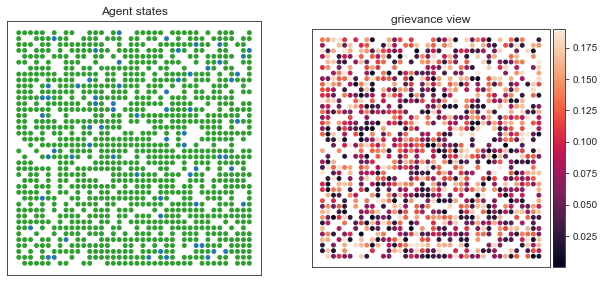

In [2]:
model = CivilViolence(cop_vision=7, citizen_vision=7, legitimacy=0.81,
                      max_jail_term=30, cop_density=0.04, citizen_density=0.7,
                      seed=123456789)
visualize_model(model)
for _ in range(500):
    model.step()

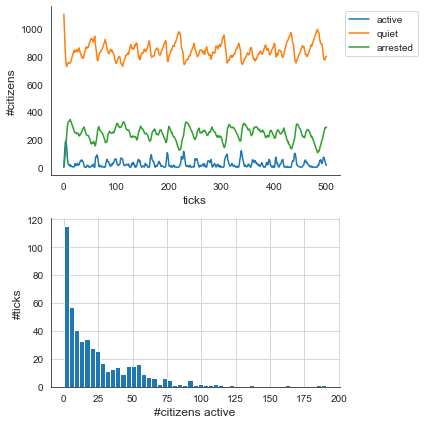

In [3]:
fig, (ax1, ax2) = plt.subplots(nrows=2, figsize=(6, 6))

data = model.datacollector.get_model_vars_dataframe()
data.plot(ax=ax1)
ax1.legend(bbox_to_anchor=(1, 1), loc='upper left')
ax1.set_xlabel('ticks', fontsize=12)
ax1.set_ylabel('#citizens', fontsize=12)

data.active.hist(bins=51, ax=ax2)
ax2.set_xlabel('#citizens active', fontsize=12)
ax2.set_ylabel('#ticks', fontsize=12)

sns.despine()
plt.tight_layout()

# save_fig(fig, '.', 'expected_results')

plt.show()


# Assignment 2
The original paper does not use the round operator in the calculation of the arrest probability. Instead, it just uses the raw ratio of number of cops within the field of vision to the number of active citizens within the field of vision. The problem is that if you follow the original paper, none of the reported dynamics can successfully be replicated. By now, there is quite a literature on this equation which is exploring alternative formulations for calculating the arrest probability. Modify the model to reflect the equation reported in Epstein (2002). That is, change round(cops/active citizens) to just cops/active citizens. Visually show the change in behaviour and explain your results.


In [4]:
class Citizen(BaseAgent):
    '''Citizen class
    
    Attributes
    ----------
    legitimacy : boolean
    vision : int
    arrest_prob_constant : float
    activation_treshold : float
    hardship : float
    risk_aversion : float
    state : {CitizenState.QUIET, CitizenState.ACTIVE, CitizenState.ARRESTED }
    jail_time_remaining  :int
    grievance : float
    
    '''        
    legitimacy = 1
    vision = 1
    arrest_prob_constant = 1
    activation_treshold = 1
    use_round = True
    
    def __init__(self, identity, model):
        super().__init__(identity, model)
        self.hardship = self.random.random()
        self.risk_aversion = self.random.random()
        self.state = CitizenState.QUIET
        self.jail_time_remaining = 0
        self.grievance = self.hardship*(1-Citizen.legitimacy)
        
    def _check_jail_time(self):
        if (self.state == CitizenState.ARRESTED) and (self.jail_time_remaining > 0):
            self.jail_time_remaining -= 1
        return self.jail_time_remaining

    def calculate_arrest_p(self, n_cops, n_active_citizens):
        if Citizen.use_round:
            p = 1 - math.exp(-1*Citizen.arrest_prob_constant * round(n_cops/n_active_citizens))
        else:
            p = 1 - math.exp(-1*Citizen.arrest_prob_constant * (n_cops/n_active_citizens))
        return p            
    
    def step(self):
        """
        move and then decide whether to activate
        """
        
        if self._check_jail_time() > 0:
            return
            
        self.move()
            
        cops, active_citizens = self.get_agents_in_vision()
        n_cops = len(cops)
        n_active_citizens = len(active_citizens) + 1 # self is always considerd active
            
        arrest_p = self.calculate_arrest_p(n_cops, n_active_citizens)
        net_risk = self.risk_aversion * arrest_p
        
        if (self.grievance - net_risk) > self.activation_threshold:
            self.state = CitizenState.ACTIVE
        else:
            self.state = CitizenState.QUIET

In [5]:
model = CivilViolence(cop_vision=7, citizen_vision=7, legitimacy=0.81,
                      max_jail_term=30, cop_density=0.04, citizen_density=0.7,
                      seed=123456789)
for _ in range(100):
    model.step()
    
data_with_round = model.datacollector.get_model_vars_dataframe()

In [6]:
Citizen.use_round = False

model = CivilViolence(cop_vision=7, citizen_vision=7, legitimacy=0.81,
                      max_jail_term=30, cop_density=0.04, citizen_density=0.7,
                      seed=123456789)
for _ in range(100):
    model.step()
    
data_no_round = model.datacollector.get_model_vars_dataframe()

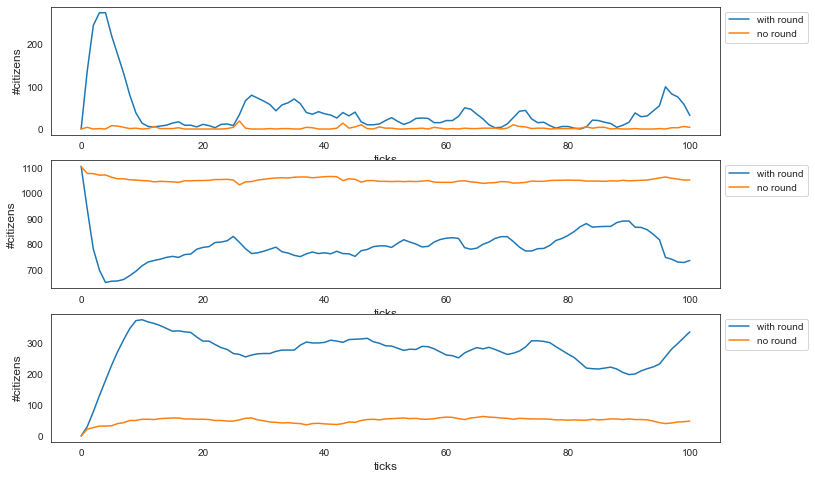

In [7]:
fig, axes = plt.subplots(nrows=3)

for i, ax in enumerate(axes):
    data_with_round.iloc[:, i].plot(ax=ax, label='with round')
    data_no_round.iloc[:, i].plot(ax=ax, label='no round')

    ax.set_xlabel('ticks', fontsize=12)
    ax.set_ylabel('#citizens', fontsize=12)        
    ax.legend(bbox_to_anchor=(1, 1), loc='upper left')
    
plt.show()

# Assignment 3
The model is quite sensitive to the perceived risks of becoming active. Explore the dynamics of the model by varying the jail time. Specifically, how does the behaviour of the model change between a jail time of 5, 15, and 30 years? Visually show the change in behaviour and explain your results.


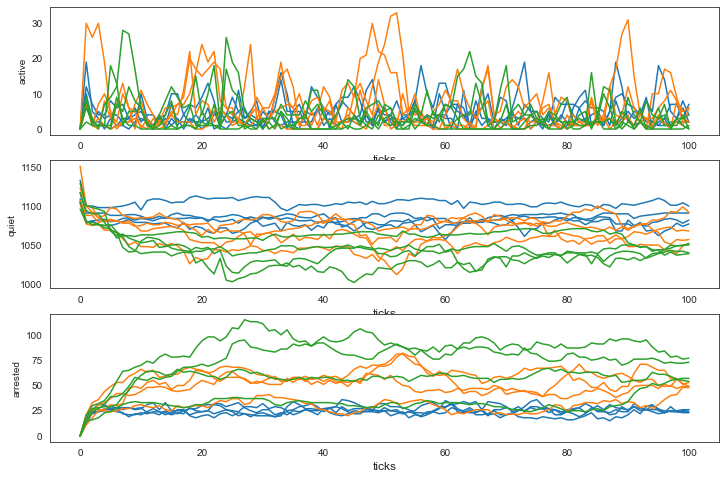

In [12]:

fig, axes = plt.subplots(nrows=3)

for ax in axes:
    ax.set_xlabel('ticks', fontsize=12)

for i, jail_time in enumerate([5, 15, 30]):
    color = sns.color_palette()[i]
    
    for seed in range(1, 5):
        model = CivilViolence(cop_vision=7, citizen_vision=7, legitimacy=0.81,
                              max_jail_term=jail_time, cop_density=0.04, citizen_density=0.7,
                              seed=seed)
        for _ in range(100):
            model.step()

        results = model.datacollector.get_model_vars_dataframe()
        
        for i, ax in enumerate(axes):
            label = results.columns.values[i]
            results.iloc[:, i].plot(ax=ax, label=f'{jail_time}', color=color)
            ax.set_ylabel(label)

plt.show()

Note that the above code is not the cleanest way to implement this. Note how the execution of the experiments and the visualization of the results are interwoven. Ideally, you would seperate the generation of the data from the results.

In this case you would build up a something like a defauldict with as key the jail time, and as value a list of results across seeds. Next, you can iterate over this for visualization purposes.

# Assignment 4
The default setup of the model uses a fixed ratio of 70% agents, and 4% cops, leaving 26% of the grid cells empty. After the storming of the United States capital, people compared the mass presence of cops at the Black Lives Matter protests with the lack of presence on January 6 when Trump supporters were protesting. We can use the model to investigate whether this might have made a difference. How does the behaviour of the model change if we move from 2% cops to 4% or 6% cops? In answering this question, ensure that at all times 26% of your grid cells remains empty. Visually show the change in behaviour and explain your results. 

In [19]:
from collections import defaultdict 

results =  defaultdict(list)
for i, cop_density in enumerate([0.02, 0.04, 0.06]):
    citizen_density = 1 - 0.26 - cop_density
    
    
    for seed in range(1, 5):
        model = CivilViolence(cop_vision=7, citizen_vision=7, legitimacy=0.81,
                              max_jail_term=jail_time, cop_density=cop_density,
                              citizen_density=citizen_density, seed=seed)
        for _ in range(100):
            model.step()

        data = model.datacollector.get_model_vars_dataframe()
        results[cop_density].append(data)


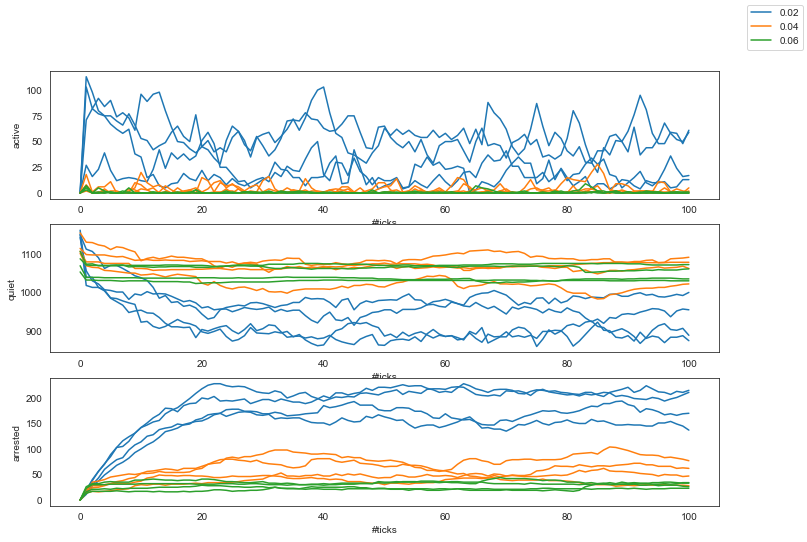

In [31]:
from matplotlib.lines import Line2D


fig, axes = plt.subplots(nrows=3)
colors = sns.color_palette()
for i, (k, v) in enumerate(results.items()):
    color = colors[i]
    for entry in v:
        for j, ax in enumerate(axes):
            ax.plot(entry.iloc[: , j], color=color)


# set up ax labels
for j, ax in enumerate(axes):
    ax.set_ylabel(results[0.02][0].columns.values[j])
    ax.set_xlabel("#ticks")

# custom legend
# see https://matplotlib.org/stable/gallery/text_labels_and_annotations/custom_legends.html
lines = []
labels = []
for i, k in enumerate(results.keys()):
    line = Line2D([0, 0], [1, 1], color=colors[i])
    label = f"{k}"
    lines.append(line)
    labels.append(label)
fig.legend(lines, labels)

plt.show()
